In [1]:
# Import packages 
import pandas as pd
import seaborn as sns
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
#from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Read file
original_df = pd.read_csv('tested_molecules_1.csv')

# Split the column
original_df[['SMILES', 'ALDH1_inhibition']] = original_df['SMILES,"ALDH1_inhibition"'].str.split(',', expand=True)
original_df.drop('SMILES,"ALDH1_inhibition"', axis=1, inplace=True)

original_df['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')


all_descriptors = [desc[0] for desc in Descriptors.descList]
descriptor_data = []
for i, row in original_df.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
    descriptor_data.append(descriptor_values)

descriptor_df = pd.DataFrame(descriptor_data, columns=all_descriptors)

original_df = pd.concat([original_df, descriptor_df], axis=1)
df = original_df.copy()




# The same needs to be done for the test_data
original_df_test = pd.read_csv('tested_molecules_2.csv')

original_df_test[['SMILES', 'ALDH1_inhibition']] = original_df_test['SMILES;ALDH1_inhibition'].str.split(';', expand=True)
original_df_test.drop('SMILES;ALDH1_inhibition', axis=1, inplace=True)

#original_df_test['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')
X_test_data = original_df_test.copy()

In [3]:
df_variables = df.drop(columns=["SMILES", "ALDH1_inhibition"])

In [4]:
new_df_variables = df_variables.copy()
corr_matrix = new_df_variables.corr(numeric_only=True).abs()
corr_matrix
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
mask

# Select upper triangle of correlation matrix using the boolean mask
upper = corr_matrix.where(mask)

# Find index of columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the columns
new_df_variables.drop(columns=to_drop, inplace=True)
new_df_variables

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,13.083531,0.001173,-0.683140,0.520365,463.542,0,0.249868,-0.496477,1.088235,1.794118,...,0,0,0,0,1,0,0,0,0,0
1,12.170097,0.066966,-0.066966,0.498564,378.457,0,0.230353,-0.467476,1.111111,2.000000,...,1,0,0,0,0,0,0,0,0,0
2,10.905837,0.016881,-0.016881,0.382043,477.589,0,0.219930,-0.492903,1.228571,2.114286,...,0,0,0,0,1,0,0,0,0,0
3,11.562446,0.270607,-0.454447,0.795948,330.609,0,0.351723,-0.421732,1.333333,2.000000,...,0,0,0,0,0,0,0,0,0,0
4,12.108866,0.086947,-3.251317,0.687618,419.553,0,0.231765,-0.301646,1.296296,2.148148,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.276695,0.095308,-0.234165,0.779148,261.301,0,0.292020,-0.496766,1.210526,1.894737,...,0,0,0,0,0,0,0,0,0,0
996,8.926724,0.197944,0.197944,0.891297,257.293,0,0.235725,-0.483868,1.473684,2.315789,...,0,0,0,0,0,0,0,0,0,0
997,10.688087,0.166502,-0.368508,0.805927,201.229,0,0.236896,-0.368122,1.333333,2.066667,...,0,0,0,0,0,0,0,0,0,0
998,12.603109,0.065686,-0.447592,0.644831,392.441,0,0.331704,-0.359541,1.296296,2.000000,...,1,0,0,0,0,0,0,0,0,0


In [5]:
df_selected = new_df_variables.copy()
missing_values = df_selected.isnull().sum().sum()     
if missing_values > 0: 
   print('Remove missing values')
else: 
   print('No missing_values')

No missing_values


In [6]:
# Scaling the data 
df_copied = new_df_variables.copy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copied)
df_scaled = pd.DataFrame(df_scaled, columns=df_copied.columns)

In [8]:
def remove_features_with_low_variance(data, threshold):
    low_variance_features = []
    
    for feature in data.columns:
        var = data[feature].var()
        
        if var < threshold:
            low_variance_features.append(feature)
    
    # Remove the features with low variance
    data = data.drop(low_variance_features, axis=1)
    
    return data

In [9]:
data_filtered = remove_features_with_low_variance(df_scaled, threshold=0.01)

#data_filtered = df_scaled_filtered.copy() 
data_filtered

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,...,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_tetrazole,fr_thiazole,fr_thiophene,fr_urea
0,0.883077,0.001001,0.732144,0.492906,0.688495,0.391821,0.477890,0.433017,0.566474,0.683594,...,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
1,0.807622,0.057684,0.821655,0.466743,0.501554,0.355044,0.514568,0.451613,0.687861,0.838542,...,0.0,0.0,0.5,0.000000,0.5,0.0,0.0,0.0,0.0,0.0
2,0.703186,0.014533,0.828931,0.326910,0.719358,0.335403,0.482409,0.547097,0.755244,0.859375,...,0.0,0.0,0.5,0.333333,0.0,0.0,1.0,0.0,0.0,0.0
3,0.757426,0.233129,0.765366,0.823627,0.396428,0.583765,0.572424,0.632258,0.687861,0.738281,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.802564,0.074898,0.359067,0.693622,0.591847,0.357705,0.724304,0.602151,0.775209,0.875000,...,0.0,0.0,0.0,0.000000,0.0,0.5,0.0,1.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.816427,0.082102,0.797366,0.803465,0.244151,0.471256,0.477524,0.532428,0.625799,0.670641,...,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
996,0.539698,0.170527,0.860138,0.938052,0.235345,0.365167,0.493837,0.746350,0.874049,0.929688,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
997,0.685198,0.143438,0.777850,0.835602,0.112166,0.367375,0.640228,0.632258,0.727168,0.798438,...,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
998,0.843391,0.056581,0.766362,0.642275,0.532279,0.546039,0.651080,0.602151,0.687861,0.729167,...,0.0,0.0,0.0,0.000000,0.5,0.0,0.0,0.0,0.0,0.0


In [10]:
# Calculate the mean for each column
mean = data_filtered.mean()

# Calculate the standard deviation for each column
std_dev = data_filtered.std()

# Iterate over each column in the dataframe
outlier_features = []
for column in data_filtered.columns:
    # Calculate the absolute difference between values and the mean
    diff = abs(data_filtered[column] - mean[column])
    
    # Check if the difference is more than four standard deviations
    if (diff > 4 * std_dev[column]).any():
        outlier_features.append(column)

# Drop the outlier features from the dataframe
data_filtered = data_filtered.drop(columns=outlier_features)
data_filtered

,MinEStateIndex,qed,MolWt,FpDensityMorgan1,BCUT2D_LOGPLOW,AvgIpc,BertzCT,PEOE_VSA12,PEOE_VSA8,PEOE_VSA9,...,FractionCSP3,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumRotatableBonds,fr_Ar_N,fr_NH0,fr_NH1,fr_piperzine
0,0.732144,0.492906,0.688495,0.433017,0.451215,0.811612,0.588410,0.739676,0.641177,0.222241,...,0.400000,0.50,0.25,0.6,0.666667,0.615385,0.666667,0.714286,0.50,0.0
1,0.821655,0.466743,0.501554,0.451613,0.630917,0.807662,0.537947,0.245987,0.122345,0.435993,...,0.160000,0.25,0.75,0.8,0.500000,0.538462,0.500000,0.428571,0.25,0.0
2,0.828931,0.326910,0.719358,0.547097,0.070915,0.957659,0.682900,0.487395,0.353620,0.301191,...,0.492308,0.25,0.75,0.8,0.666667,0.692308,0.833333,0.714286,0.25,0.0
3,0.765366,0.823627,0.396428,0.632258,0.649601,0.249123,0.294647,0.000000,0.596825,0.087225,...,0.328205,0.25,0.25,0.4,0.250000,0.230769,0.000000,0.142857,0.00,0.0
4,0.359067,0.693622,0.591847,0.602151,0.612789,0.802148,0.574670,0.663378,0.441564,0.417799,...,0.237037,0.25,0.50,0.6,0.500000,0.384615,0.166667,0.285714,0.25,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.797366,0.803465,0.244151,0.532428,0.196567,0.714663,0.216412,0.245987,0.253534,0.438673,...,0.457143,0.25,0.00,0.2,0.250000,0.307692,0.000000,0.142857,0.00,0.0
996,0.860138,0.938052,0.235345,0.746350,0.808585,0.492140,0.272621,0.727439,0.129214,0.000000,...,0.304762,0.25,0.25,0.4,0.416667,0.384615,0.166667,0.285714,0.25,0.0
997,0.777850,0.835602,0.112166,0.632258,0.676192,0.418587,0.187871,0.245987,0.232185,0.208766,...,0.096970,0.25,0.25,0.4,0.250000,0.230769,0.333333,0.285714,0.00,0.0
998,0.766362,0.642275,0.532279,0.602151,0.547441,0.724291,0.604398,0.245987,0.517341,0.099906,...,0.466667,0.00,0.75,0.6,0.833333,0.384615,0.833333,0.714286,0.25,0.0


In [11]:
x_train = data_filtered
y_train = df['ALDH1_inhibition']
estimator = RandomForestClassifier(random_state = 42)
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(x_train, y_train)
rfe_mask = selector.get_support() #list of booleans for selected features
new_features = [] 
for bool, feature in zip(rfe_mask, x_train.columns):
    if bool:
        new_features.append(feature)
new_features # The list of your 5 best features

['MinEStateIndex',
 'qed',
 'MolWt',
 'FpDensityMorgan1',
 'BCUT2D_LOGPLOW',
 'AvgIpc',
 'BertzCT',
 'PEOE_VSA12',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA10',
 'SMR_VSA7',
 'SlogP_VSA1',
 'SlogP_VSA3',
 'SlogP_VSA6',
 'EState_VSA2',
 'EState_VSA6',
 'EState_VSA7',
 'VSA_EState6',
 'FractionCSP3']

In [12]:
df_selected_features = data_filtered.loc[:, new_features]
df_selected_features

,MinEStateIndex,qed,MolWt,FpDensityMorgan1,BCUT2D_LOGPLOW,AvgIpc,BertzCT,PEOE_VSA12,PEOE_VSA8,PEOE_VSA9,SMR_VSA10,SMR_VSA7,SlogP_VSA1,SlogP_VSA3,SlogP_VSA6,EState_VSA2,EState_VSA6,EState_VSA7,VSA_EState6,FractionCSP3
0,0.732144,0.492906,0.688495,0.433017,0.451215,0.811612,0.588410,0.739676,0.641177,0.222241,0.254207,0.479709,0.631331,0.392848,0.502180,0.360296,0.161402,0.642042,0.573427,0.400000
1,0.821655,0.466743,0.501554,0.451613,0.630917,0.807662,0.537947,0.245987,0.122345,0.435993,0.412637,0.624993,0.165594,0.438835,0.704842,0.235272,0.253587,0.428028,0.604821,0.160000
2,0.828931,0.326910,0.719358,0.547097,0.070915,0.957659,0.682900,0.487395,0.353620,0.301191,0.156035,0.521269,0.152610,0.437420,0.433023,0.483127,0.085729,0.493167,0.430478,0.492308
3,0.765366,0.823627,0.396428,0.632258,0.649601,0.249123,0.294647,0.000000,0.596825,0.087225,0.632381,0.303917,0.327822,0.000000,0.293261,0.090249,0.000000,0.214014,0.239746,0.328205
4,0.359067,0.693622,0.591847,0.602151,0.612789,0.802148,0.574670,0.663378,0.441564,0.417799,0.707308,0.410909,0.299682,0.678703,0.377959,0.119193,0.155177,0.483225,0.357358,0.237037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.797366,0.803465,0.244151,0.532428,0.196567,0.714663,0.216412,0.245987,0.253534,0.438673,0.250473,0.193488,0.465736,0.235295,0.223191,0.360296,0.429461,0.062523,0.289083,0.457143
996,0.860138,0.938052,0.235345,0.746350,0.808585,0.492140,0.272621,0.727439,0.129214,0.000000,0.084210,0.330223,0.313126,0.162118,0.263819,0.248201,0.000000,0.519564,0.362504,0.304762
997,0.777850,0.835602,0.112166,0.632258,0.676192,0.418587,0.187871,0.245987,0.232185,0.208766,0.084539,0.341724,0.178578,0.278241,0.394185,0.251250,0.233943,0.356690,0.364998,0.096970
998,0.766362,0.642275,0.532279,0.602151,0.547441,0.724291,0.604398,0.245987,0.517341,0.099906,0.495898,0.260461,0.515950,0.463516,0.233028,0.357182,0.336788,0.162841,0.111761,0.466667


In [13]:
# Create principal components
pca = PCA()
df_pca = pca.fit_transform(df_selected_features)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca_converted = pd.DataFrame(df_pca, columns=component_names)

df_pca_converted.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,0.641417,0.205240,0.380627,-0.421746,-0.002074,0.009142,0.393036,0.119036,0.068403,-0.014310,0.095594,-0.133655,-0.088007,0.037851,-0.100134,0.015289,-0.039684,-0.001916,-0.073700,-0.000582
1,0.503859,-0.298943,0.092231,-0.021466,0.016275,-0.392801,-0.058752,-0.099600,0.007298,-0.171380,0.093922,0.041137,0.063701,-0.113571,0.025207,0.036801,-0.089911,0.018580,0.053752,0.040374
2,0.510438,0.330448,0.560941,-0.146174,-0.057909,-0.328405,-0.064416,-0.043163,0.206206,-0.154012,-0.043549,-0.298961,0.183394,0.022560,-0.088991,-0.105357,0.128722,-0.035604,-0.055742,0.008812
3,-0.399295,-0.134787,-0.030618,-0.133022,-0.242180,0.296961,0.055995,0.041007,-0.341801,0.149413,-0.182705,0.058018,0.009099,-0.035545,0.098086,-0.114214,-0.093590,0.035229,0.029890,0.031374
4,0.493733,0.326752,-0.065330,-0.425248,0.131206,-0.192664,0.107658,-0.097336,-0.512658,-0.154422,0.079771,0.141095,0.033184,-0.080282,-0.092188,0.051415,0.027604,0.016527,0.014704,-0.060661


In [14]:
# Explained variance
evr = pca.explained_variance_ratio_
print(evr*100)
    
# Cumaltive Variance
cv = np.cumsum(evr)
print(cv)                                # NEED 46 Principal components for 90% , 11 for 60% 

[23.68274142 15.87117313  9.49726014  8.17735619  6.4328488   6.1258394
  4.93687512  4.23912826  3.72440978  3.23363526  2.87377441  2.57094429
  2.30255428  2.1313846   1.92946808  0.80664149  0.68659647  0.30973759
  0.24764633  0.21998498]
[0.23682741 0.39553915 0.49051175 0.57228531 0.6366138  0.69787219
 0.74724094 0.78963222 0.82687632 0.85921267 0.88795042 0.91365986
 0.9366854  0.95799925 0.97729393 0.98536035 0.99222631 0.99532369
 0.99780015 1.        ]


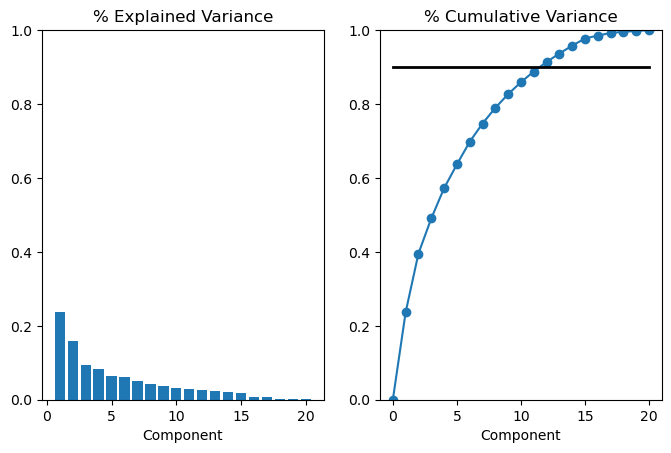

In [15]:
# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].plot([0, n], [0.9, 0.9], color='k', linestyle='-', linewidth=2)
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)
        
# Set up figure
fig.set(figwidth=8, dpi=100);

In [16]:
loadings = pd.DataFrame(
   pca.components_.T,                     # transpose the pca matrix 
   columns=component_names,               # so the columns are the principal components
   index=df_selected_features.columns,                      # and the rows are the original features
)
loadings      

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
MinEStateIndex,-0.158549,-0.239299,0.407335,0.023741,-0.406500,-0.042297,0.273169,-0.291651,0.365093,0.003564,0.193511,0.150972,0.147099,-0.358649,0.204179,-0.167963,0.000729,0.004713,-0.007443,0.103000
qed,-0.237293,-0.066282,0.004469,-0.240886,0.582630,0.215488,0.015544,-0.509488,-0.115574,0.396152,-0.007712,0.100973,-0.096350,-0.099635,0.097599,-0.154962,-0.009007,0.026974,0.023035,0.030054
MolWt,0.349104,0.182077,0.084821,0.063279,-0.051742,0.017160,-0.049559,-0.018535,-0.115873,0.098586,0.000059,0.003470,0.023511,0.147281,0.169717,-0.448998,-0.060039,0.400762,-0.572398,0.245652
FpDensityMorgan1,-0.181524,0.062612,-0.074973,0.010890,-0.183397,-0.141666,0.074308,-0.227552,-0.243296,0.001000,-0.065744,-0.237724,0.134028,-0.171896,-0.706416,-0.287410,-0.294953,-0.068163,-0.073584,0.012560
BCUT2D_LOGPLOW,-0.006110,-0.230449,-0.480822,-0.295998,-0.282541,-0.138584,-0.047847,0.011669,-0.008539,0.047901,0.327160,0.232724,-0.512747,0.023767,0.069169,-0.110962,-0.282753,0.046921,0.003297,-0.017208
AvgIpc,0.287155,0.088492,0.171244,-0.109789,-0.104483,-0.218153,-0.120200,-0.528971,-0.098361,-0.066176,0.238226,-0.489472,-0.133722,0.111157,0.115262,0.385150,-0.035301,0.063062,0.017704,-0.088203
BertzCT,0.369724,0.021370,0.023987,0.029142,-0.048808,-0.032018,-0.046185,-0.045647,-0.117076,0.050895,0.033389,-0.091707,-0.148879,-0.008240,0.078746,-0.481399,0.318032,-0.641381,0.222651,0.075564
PEOE_VSA12,0.187566,0.346641,-0.146395,-0.484842,0.163361,-0.131225,0.584074,-0.044821,0.207981,-0.349026,-0.160109,0.032657,0.030374,-0.031798,0.007178,-0.063335,0.022112,0.023020,0.019318,-0.043966
PEOE_VSA8,0.160257,0.145703,0.174812,-0.293326,-0.298437,0.765852,-0.135656,-0.007848,-0.031488,-0.069415,-0.135859,0.038764,-0.211749,-0.169748,-0.167590,0.119565,-0.020397,0.000408,-0.005104,-0.013553
PEOE_VSA9,0.127678,0.152943,0.231702,0.404579,0.116393,-0.208324,-0.008804,-0.219469,-0.099094,-0.242971,-0.227417,0.490903,-0.469914,-0.138419,-0.133276,0.082328,-0.078159,0.048827,0.050462,-0.025067


In [17]:
def plot_loadings(PC_1, PC_2):
    labels = loadings.index
    sns.set_style('white')
    sns.scatterplot(data=loadings, x=PC_1, y=PC_2, hue=labels, palette = 'Paired')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')
    plt.axline((-0.2, -0.2), slope = 1,color ='r', linestyle = 'dotted')

    plt.legend(ncol =5, title = 'Variables', loc='center left', bbox_to_anchor=(1.0, 0.5))

Text(0.5, 1.0, 'Loadings principal components 1 and 2')

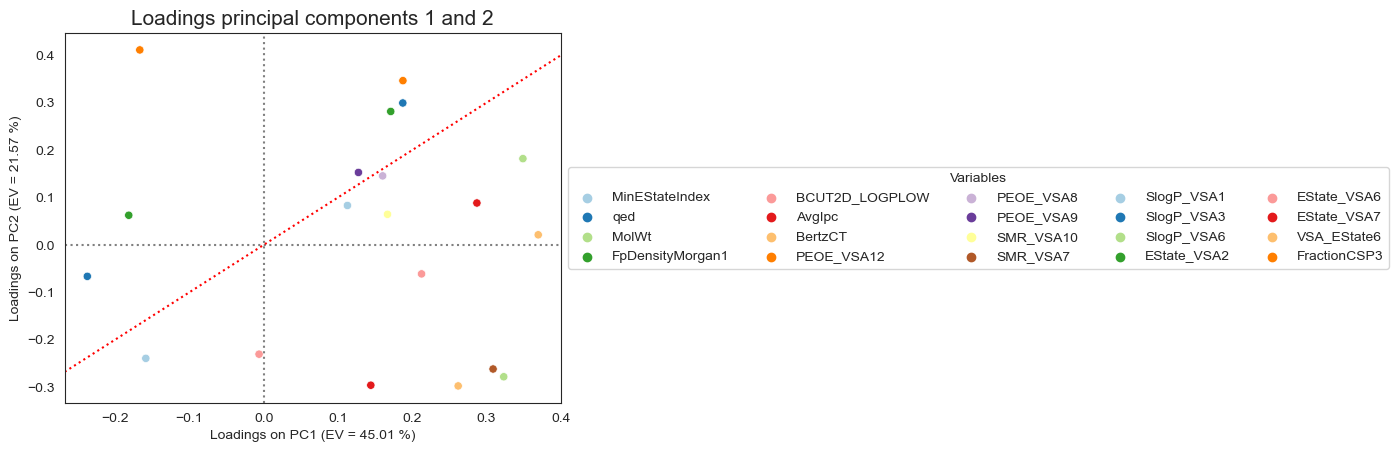

In [18]:
plot_loadings(PC_1 ='PC1', PC_2= 'PC2')               # IS ZO NIETS ZICHTBAAR< Worden te veel variabelen meegenomen. 

plt.xlabel('Loadings on PC1 (EV = 45.01 %)')
plt.ylabel('Loadings on PC2 (EV = 21.57 %)')
plt.title('Loadings principal components 1 and 2', fontsize = 15)

In [19]:
def plot_scores(label,PC_1, PC_2):
    labels = original_df[label]
    sns.set_style('white')
    sns.scatterplot(x=df_pca[:, PC_1], y=df_pca[:, PC_2], hue=labels, palette= 'bright')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')

    plt.legend(loc= 'best', ncol =2, title = label)

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

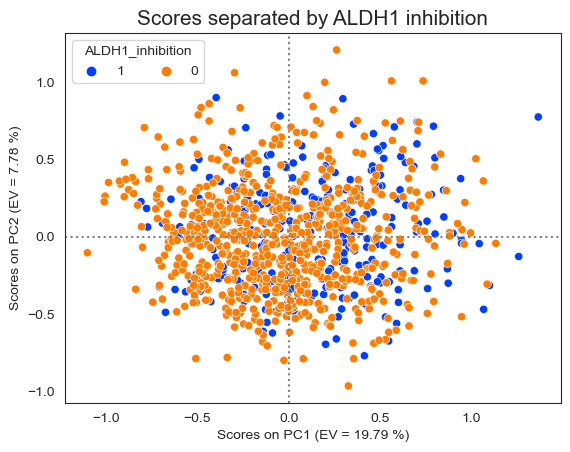

In [20]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 0 , PC_2 = 1)

plt.xlabel('Scores on PC1 (EV = 19.79 %)')
plt.ylabel('Scores on PC2 (EV = 7.78 %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

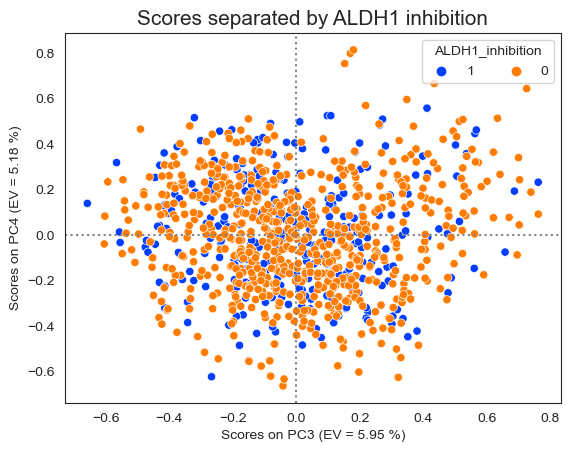

In [21]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 2 , PC_2 = 3)

plt.xlabel('Scores on PC3 (EV = 5.95 %)')
plt.ylabel('Scores on PC4 (EV = 5.18 %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

In [22]:
#X_test = X_test_data['SMILES']
selected_descriptors = [desc for desc in all_descriptors if desc in df_selected_features.columns]
descriptor_data = []
for i, row in X_test_data.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in selected_descriptors]
    descriptor_data.append(descriptor_values)

descriptor_df = pd.DataFrame(descriptor_data, columns=selected_descriptors)
X_test_all_columns_before = pd.concat([X_test_data, descriptor_df], axis=1)
X_test_all_columns = X_test_all_columns_before.drop(columns=["SMILES", "ALDH1_inhibition"])
X_test_all_columns_scaled = X_test_all_columns.copy()
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test_all_columns_scaled)
X_test = pd.DataFrame(X_test, columns=X_test_all_columns.columns)
y_test = X_test_all_columns_before['ALDH1_inhibition']


#X_test = X_test_all_columns.drop(columns=["SMILES", "ALDH1_inhibition"])
#y_test = X_test_data['ALDH1_inhibition']
X_train = df_pca
y_train = original_df['ALDH1_inhibition']

#tree = DecisionTreeClassifier()
#tree.fit(X_train, y_train)
#y_pred = tree.predict(X_test)

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.779


C:\Users\20213276\.conda\envs\my-rdkit-env\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [23]:
all_descriptors = [desc[0] for desc in Descriptors.descList]
all_descriptors

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VS

In [24]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

# Load a molecule from SMILES
smiles = 'CCO'
mol = Chem.MolFromSmiles(smiles)

# Generate the binary fingerprint
fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2)  # Example using Morgan fingerprint

# Get the length of the fingerprint (number of bits)
num_bits = fingerprint.GetNumBits()

# Generate feature names based on bit positions
feature_names = ['Bit_{}'.format(i) for i in range(num_bits)]

print(feature_names)

['Bit_0', 'Bit_1', 'Bit_2', 'Bit_3', 'Bit_4', 'Bit_5', 'Bit_6', 'Bit_7', 'Bit_8', 'Bit_9', 'Bit_10', 'Bit_11', 'Bit_12', 'Bit_13', 'Bit_14', 'Bit_15', 'Bit_16', 'Bit_17', 'Bit_18', 'Bit_19', 'Bit_20', 'Bit_21', 'Bit_22', 'Bit_23', 'Bit_24', 'Bit_25', 'Bit_26', 'Bit_27', 'Bit_28', 'Bit_29', 'Bit_30', 'Bit_31', 'Bit_32', 'Bit_33', 'Bit_34', 'Bit_35', 'Bit_36', 'Bit_37', 'Bit_38', 'Bit_39', 'Bit_40', 'Bit_41', 'Bit_42', 'Bit_43', 'Bit_44', 'Bit_45', 'Bit_46', 'Bit_47', 'Bit_48', 'Bit_49', 'Bit_50', 'Bit_51', 'Bit_52', 'Bit_53', 'Bit_54', 'Bit_55', 'Bit_56', 'Bit_57', 'Bit_58', 'Bit_59', 'Bit_60', 'Bit_61', 'Bit_62', 'Bit_63', 'Bit_64', 'Bit_65', 'Bit_66', 'Bit_67', 'Bit_68', 'Bit_69', 'Bit_70', 'Bit_71', 'Bit_72', 'Bit_73', 'Bit_74', 'Bit_75', 'Bit_76', 'Bit_77', 'Bit_78', 'Bit_79', 'Bit_80', 'Bit_81', 'Bit_82', 'Bit_83', 'Bit_84', 'Bit_85', 'Bit_86', 'Bit_87', 'Bit_88', 'Bit_89', 'Bit_90', 'Bit_91', 'Bit_92', 'Bit_93', 'Bit_94', 'Bit_95', 'Bit_96', 'Bit_97', 'Bit_98', 'Bit_99', 'Bit_100'

In [25]:


# Load a molecule from SMILES
smiles = 'CCO'
mol = Chem.MolFromSmiles(smiles)

# Generate the Morgan fingerprint with radius 2
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2)

# Convert the fingerprint to a binary string
binary_string = fingerprint.ToBitString()

print(binary_string)

0000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [26]:
# X_train = data_filtered
# Y_train = df['ALDH1_inhibition']

# selected_descriptors = [desc for desc in all_descriptors if desc in data_filtered.columns]
# descriptor_data = []
# for i, row in X_test_data.iterrows():
#     mol = Chem.MolFromSmiles(row['SMILES'])
#     descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in selected_descriptors]
#     descriptor_data.append(descriptor_values)

# descriptor_df = pd.DataFrame(descriptor_data, columns=selected_descriptors)
# X_test_all_columns_before = pd.concat([X_test_data, descriptor_df], axis=1)
# X_test_all_columns = X_test_all_columns_before.drop(columns=["SMILES", "ALDH1_inhibition"])
# X_test_all_columns_scaled = X_test_all_columns.copy()
# scaler = MinMaxScaler()
# X_test = scaler.fit_transform(X_test_all_columns_scaled)
# X_test = pd.DataFrame(X_test, columns=X_test_all_columns_scaled.columns)
# y_test = X_test_all_columns_before['ALDH1_inhibition']


# cv_estimator = RandomForestClassifier(random_state =42)
# cv_estimator.fit(X_train, Y_train)
# cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
# cv_selector = cv_selector.fit(X_train, Y_train)
# rfecv_mask = cv_selector.get_support() #list of booleans
# rfecv_features = [] 
# for bool, feature in zip(rfecv_mask, X_train.columns):
#     if bool:
#         rfecv_features.append(feature)
        
# print('Optimal number of features :', cv_selector.n_features_)
# print('Best features :', rfecv_features)

# n_features = X_train.shape[1]
# plt.figure(figsize=(8,8))
# plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
# plt.yticks(np.arange(n_features), X_train.columns.values) 
# plt.xlabel('Feature importance')
# plt.ylabel('Feature')
# plt.show()

In [27]:
# # X_train = data_filtered
# Y_train = df['ALDH1_inhibition']

# selected_descriptors = [desc for desc in all_descriptors if desc in data_filtered.columns]
# descriptor_data = []
# for i, row in X_test_data.iterrows():
#     mol = Chem.MolFromSmiles(row['SMILES'])
#     descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in selected_descriptors]
#     descriptor_data.append(descriptor_values)

# descriptor_df = pd.DataFrame(descriptor_data, columns=selected_descriptors)
# X_test_all_columns_before = pd.concat([X_test_data, descriptor_df], axis=1)
# X_test_all_columns = X_test_all_columns_before.drop(columns=["SMILES", "ALDH1_inhibition"])
# X_test_all_columns_scaled = X_test_all_columns.copy()
# scaler = MinMaxScaler()
# X_test = scaler.fit_transform(X_test_all_columns_scaled)
# X_test = pd.DataFrame(X_test, columns=X_test_all_columns_scaled.columns)
# y_test = X_test_all_columns_before['ALDH1_inhibition']


# cv_estimator = RandomForestClassifier(random_state =42)
# cv_estimator.fit(X_train, Y_train)
# cv_selector = RFECV(cv_estimator,cv= 5, step=1,scoring='accuracy')
# cv_selector = cv_selector.fit(X_train, Y_train)
# rfecv_mask = cv_selector.get_support() #list of booleans
# rfecv_features = [] 
# for bool, feature in zip(rfecv_mask, X_train.columns):
#     if bool:
#         rfecv_features.append(feature)
        
# print('Optimal number of features :', cv_selector.n_features_)
# print('Best features :', rfecv_features)

# n_features = X_train.shape[1]
# plt.figure(figsize=(8,8))
# plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
# plt.yticks(np.arange(n_features), X_train.columns.values) 
# plt.xlabel('Feature importance')
# plt.ylabel('Feature')
# plt.show()

In [28]:
# Had no clue how to remove points, based on statistic, so just used chatGPT to get the data with lower amount of 
# than 50 outliers
# def remove_features_with_outliers(data, threshold):
#     outlier_count = []
#     features_to_remove = []
    
#     for feature in data.columns:
#         # Calculate the IQR (Interquartile Range) for the current feature
#         Q1 = data[feature].quantile(0.25)
#         Q3 = data[feature].quantile(0.75)
#         IQR = Q3 - Q1
        
#         # Define the lower and upper bounds for outliers
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         # Count the number of outliers
#         outliers_count = ((data[feature] < lower_bound) | (data[feature] > upper_bound)).sum()
        
#         # Append the feature and its outlier count to the list
#         outlier_count.append((feature, outliers_count))
        
#         # Check if the feature has more outliers than the threshold
#         if outliers_count > threshold:
#             features_to_remove.append(feature)
    
#     # Sort the features based on the outlier count (from lowest to highest)
#     outlier_count.sort(key=lambda x: x[1])
    
#     # Remove the features with more outliers than the threshold
#     data = data.drop(features_to_remove, axis=1)
    
#     return data

In [29]:
# all_descriptors = [desc[0] for desc in Descriptors.descList]
# descriptor_data = []
# for i, row in original_df.iterrows():
#     mol = Chem.MolFromSmiles(row['SMILES'])
#     descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
#     descriptor_data.append(descriptor_values)

# descriptor_df = pd.DataFrame(descriptor_data, columns=all_descriptors)

# original_df = pd.concat([original_df, descriptor_df], axis=1)

# original_df['Morgan_Fingerprint'] = original_df['SMILES'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), radius=3, nBits=1024))
# original_df['Morgan_Fingerprint'] = original_df['Morgan_Fingerprint'].apply(lambda x: x.ToBitString())
# bit_columns = [f'Bit_{i}' for i in range(1024)]  # Adjust the range based on the desired fingerprint size



# bit_data = original_df['Morgan_Fingerprint'].apply(list).tolist()
# bit_df = pd.DataFrame(bit_data, columns=bit_columns, index=original_df.index).astype(int)

# df = pd.concat([original_df, bit_df], axis=1)

In [ ]:
# df['ALDH1_inhibition'] = df['ALDH1_inhibition'].astype('int64')
# correlations = df_scaled.corrwith(df['ALDH1_inhibition'])
# correlations = correlations.abs().sort_values(ascending=False)
# correlations

# # Filter out features with NaN correlation and correlation lower than or equal to 0.05
# df_scaled_filtered = df_scaled.loc[:, (~correlations.isna()) & (correlations >= 0.05)]
# df_scaled_filtered
# correlations = df_scaled_filtered.corrwith(df['ALDH1_inhibition'])
# correlations = correlations.abs().sort_values(ascending=False)
# correlations